# ATMOS 2022 - MODIS Analysis

-----------

## 0. Import Libraries

In [3]:
from utils.data import *
from utils.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## 1. Creating Urban-Rural Temperature Dataset

In [14]:
provinces = ['istanbul', 'ankara']
class_types = ['urban', 'rural']
source_type = 'terra'

# numbers starting with 2 or 3: urban
# numbers starting with 1 except 10: rural
# number 10: water
urban_tiles = [21,22,23,30]
rural_tiles = [11,12,13]
lu_year = 2000

In [21]:
modis_data_dict = {}
# add urban and rural variables to the given province modis data
for province in provinces:
    
    # open modis and land use data
    province_lu_data = retrieve_ghs(province=province)
    province_modis_data = retrieve_modis_merged(province=province, source_type=source_type)
    
    # reproject modis data to match the grid of lu data
    lu_repr, modis_repr = regrid_match(province_lu_data, province_modis_data,  
                                       province_lu_data.rio.crs, province_modis_data.rio.crs,
                                       'x', 'y',
                                       'x', 'y')   
    
    # classify land use data to urban and rural tiles
    lu_repr_class = classify_urban_rural(lu_repr.sel(time=lu_year), urban_tiles, rural_tiles) 
    
    # K to C
    modis_repr = modis_repr - 273.15 
    
    # remove automatically created very big values (due to reprojection) and make a dataset
    modis_repr_copy = xr.where(modis_repr>500, np.nan, modis_repr).to_dataset(name='temp')
    
    # assign new variables named 'urban' and 'rural' containing the 'urban' and 'rural' tiles, respectively
    modis_repr_copy_class = modis_repr_copy.assign(urban=lambda x: xr.where(lu_repr_class==1, x.temp, np.nan)).transpose('time', 'y', 'x')
    modis_repr_copy_class = modis_repr_copy_class.assign(rural=lambda x: xr.where(lu_repr_class==0, x.temp, np.nan)).transpose('time', 'y', 'x')
    
    modis_data_dict[province] = modis_repr_copy_class

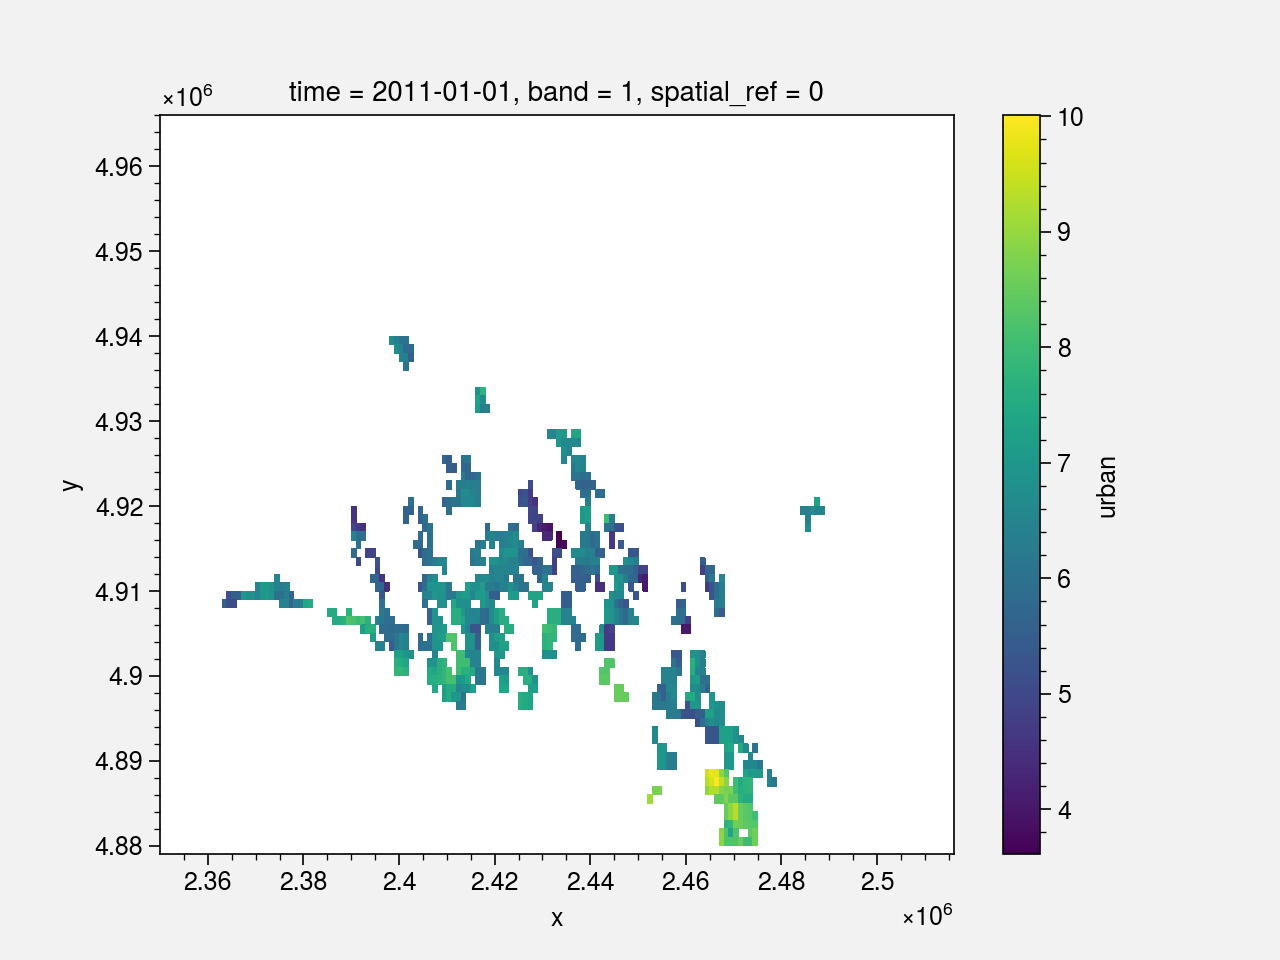

In [22]:
modis_data_dict['istanbul'].urban[0].plot()

## 2. Creating Urban-Rural Histograms

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/ui.py:406: ProPlotWarning: You specified both figsize=(6, 3) and axwidth=1.5. Ignoring 'axwidth'.
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = f

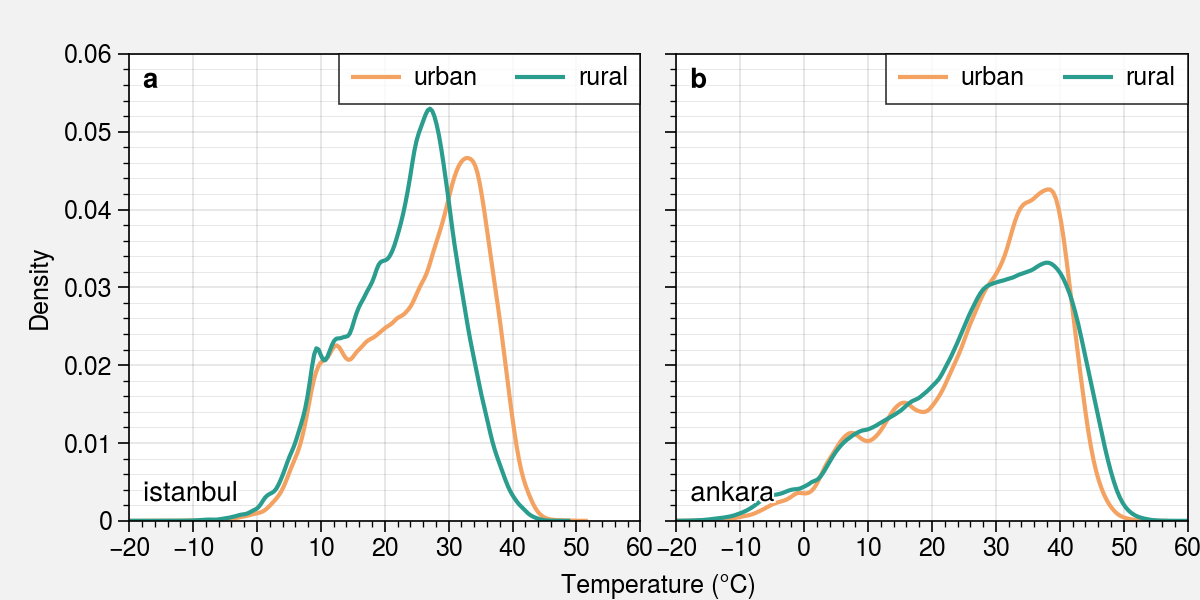

In [28]:
# start figure
f, axs = proplot.subplots(array=[[1, 2]], hratios=(1),
                          hspace=0.20, figsize=(6,3),
                          share=3, axwidth=1.5, tight=False)

# colors for lines
color_map = {'urban': '#f4a261',
             'rural': '#2a9d8f'}

# make kdeplots containing urban and rural temperature distributions
for i, province in enumerate(provinces):
    
    # flatten and make a list out of the xarray datasets before plotting
    flatten_data_urban = remove_nan_from_array(np.array(modis_data_dict[province]['urban']).flatten())
    flatten_data_rural = remove_nan_from_array(np.array(modis_data_dict[province]['rural']).flatten())
    
    sns.kdeplot(flatten_data_urban, ax=axs[i], color=color_map['urban'], label='urban', legend=True)
    sns.kdeplot(flatten_data_rural, ax=axs[i], color=color_map['rural'], label='rural', legend=True)

# format subfigures
for i in range(2):
    axs[i].format(ylabel='Density', xlabel='Temperature (°C)',
                  ygridminor=True, ygrid=True, title=provinces[i],
                  titleloc='ll', xrotation=0, xlim=(-20, 60), ylim=(0, 0.06),
                  xlocator=proplot.arange(-20, 60, 10))

# format whole figure
axs.format(abcloc='ul', abc=True,)
axs.legend()
    
# savefig    
plt.savefig(fr'pictures/modis_pdf_fig.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=300)

## 3. Creating Yearly, Monthly, and Seasonal Mean Line Plots

Get yearly, monthly, and seasonal value lists and make a separate dataframe for each of these lists

In [145]:
modis_data_dict['istanbul']

<xarray.Dataset>
Dimensions:      (x: 166, y: 87, time: 2899)
Coordinates:
  * x            (x) float64 2.35e+06 2.352e+06 ... 2.514e+06 2.516e+06
  * y            (y) float64 4.966e+06 4.964e+06 4.964e+06 ... 4.88e+06 4.88e+06
  * time         (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
    band         int64 1
    spatial_ref  int64 0
Data variables:
    temp         (time, y, x) float32 nan nan nan nan 6.27 ... nan nan nan nan
    urban        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>
    rural        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>

In [72]:
yearly_mean_dict = {}
monthly_mean_dict = {}
seasonal_mean_dict = {}


for province in provinces:
    for class_type in class_types:
        
        # get a list of mean yearly values 
        yearly_list = modis_data_dict[province].resample(time='1Y') \
                                               .mean(dim=['time', 'x', 'y'])[class_type].values
        
        # get a list of mean monthly values 
        monthly_list = modis_data_dict[province].groupby('time.month') \
                                                .mean().mean(dim=['x', 'y'])[class_type].values
        
        # get a list of mean seasonal values 
        seasonal_list = modis_data_dict[province].groupby('time.season') \
                                                   .mean().mean(dim=['x', 'y'])[class_type] \
                                                   .sel(season = ['DJF', 'MAM', 'JJA', 'SON']).values
        
        # add lists to the dictionaries
        yearly_mean_dict[fr'{province}-{class_type}'] = yearly_list
        monthly_mean_dict[fr'{province}-{class_type}'] = monthly_list     
        seasonal_mean_dict[fr'{province}-{class_type}'] = seasonal_list                

In [160]:
yearly_mean_df = pd.DataFrame(yearly_mean_dict, index=np.arange(2011,2019))
monthly_mean_df = pd.DataFrame(monthly_mean_dict, index=np.arange(1,13))
seasonal_mean_df = pd.DataFrame(seasonal_mean_dict, index=['DJF', 'MAM', 'JJA', 'SON'])

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/ui.py:406: ProPlotWarning: You specified both figsize=(9, 6) and axwidth=1.5. Ignoring 'axwidth'.
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/axes/plot.py:507: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  kw[xname + 'formatter'] = mticker.IndexFormatter(x)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibD

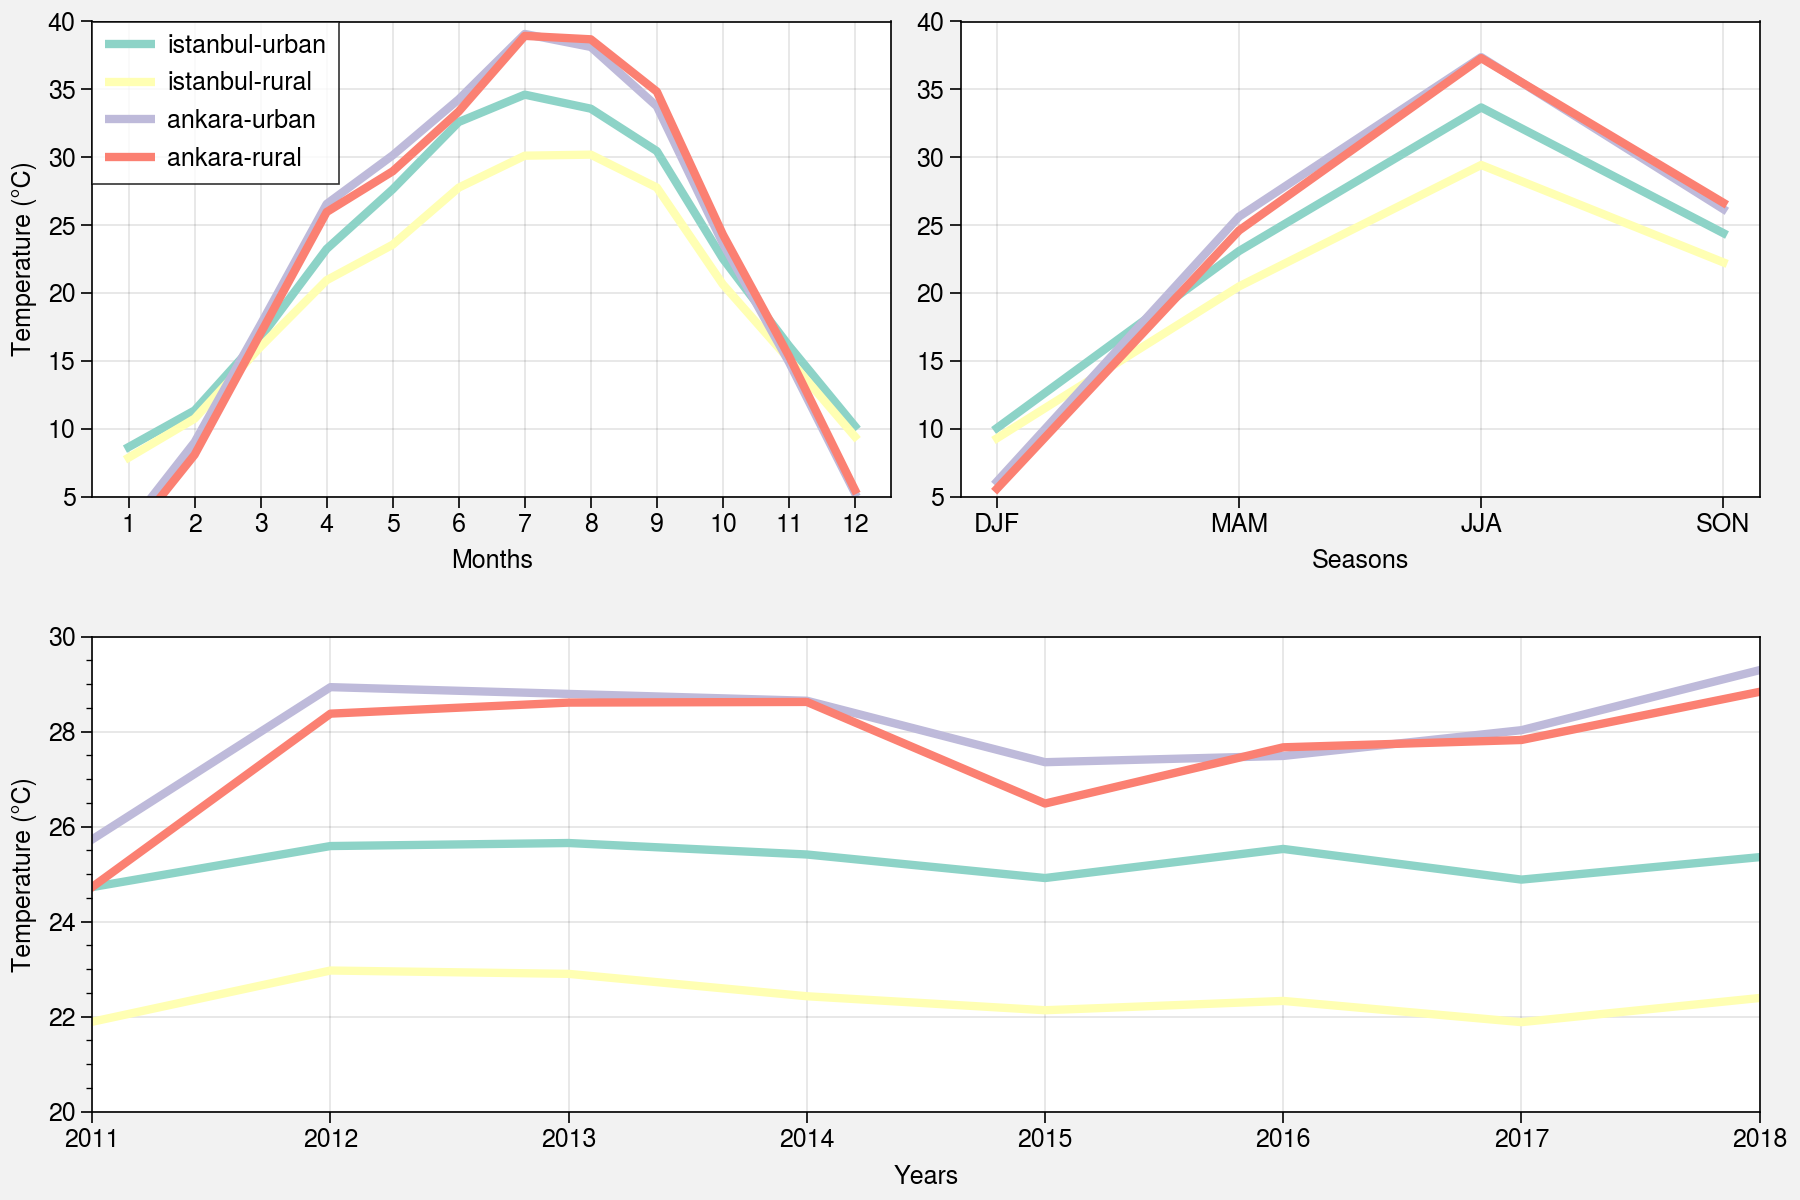

In [200]:
# start figure
f, axs = proplot.subplots(array=[[1, 1, 2, 2],
                                 [1, 1, 2, 2],
                                 [3, 3, 3, 3], 
                                 [3, 3, 3, 3]], 
                          hratios=(1,), share=False, sharey=False,
                          hspace=0.70, figsize=(9,6), axwidth=1.5, tight=True)

# colors for lines
color_map = {'urban': '#f4a261',
             'rural': '#2a9d8f'}

lp1 = axs[0].plot(monthly_mean_df, cycle='Set3', lw=3)
lp2 = axs[1].plot(seasonal_mean_df, cycle='Set3', lw=3)
lp3 = axs[2].plot(yearly_mean_df, cycle='Set3', lw=3)

axs[0].legend(loc='ul', ncols=1, facecolor='white')
#axs[0].legend(loc='ul', ncols=4,)


axs[2].format(ylabel='Temperature (°C)', xlabel='Years',
                  ygridminor=False,
                  titleloc='ll', xrotation=0, ylim=(20, 30),
                  xlocator=proplot.arange(2011, 2019, 1),
                  xlim=(2011,2018),
                  xtickminor=False)

axs[0].format(ylabel='Temperature (°C)', xlabel='Months',
                  ygridminor=False, ygrid=True, 
                  titleloc='ll', xrotation=0, ylim=(5,40),
                  xlocator=proplot.arange(1, 13, 1), 
                  xtickminor=False, ytickminor=False)

axs[1].format(xlabel='Seasons',
                  ygridminor=False, ygrid=True, 
                  titleloc='ll', xrotation=0, ylim=(5,40),
                  xtickminor=False, ytickminor=False)

# savefig    
plt.savefig(fr'pictures/modis_time_mean_fig.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=300)